# CS4681 - Advanced Machine Learning
## Programming Assignment

Index No: 200421U

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [ ]:
import pickle

In [ ]:
cudnn.bechannelshmark = True
random.seed(42)
torch.manual_seed(42)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
dataset = dset.MNIST(root='./data', download=True,
                       transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=100,
                                         shuffle=True, num_workers=2)


Failed to download (trying next):

HTTP Error 403: Forbidden






100%|██████████| 9912422/9912422 [00:01<00:00, 5840688.04it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Failed to download (trying next):

HTTP Error 403: Forbidden






100%|██████████| 28881/28881 [00:00<00:00, 153178.68it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Failed to download (trying next):

HTTP Error 403: Forbidden






100%|██████████| 1648877/1648877 [00:01<00:00, 1475266.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Failed to download (trying next):

HTTP Error 403: Forbidden






100%|██████████| 4542/4542 [00:00<00:00, 2696465.50it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




In [ ]:
z_dim = 100
filter_size = 64
channels = 1

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Generator Network

In [ ]:
class Generator(nn.Module):
    def __init__(self, channels=1, z_dim=100, filter_size=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, filter_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(filter_size * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(filter_size * 8, filter_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(filter_size * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(filter_size * 4, filter_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(filter_size * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(filter_size * 2, filter_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(filter_size),
            nn.ReLU(True),
            nn.ConvTranspose2d(filter_size, channels, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output

### Discriminator Network

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels=1, filter_size=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, filter_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(filter_size, filter_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(filter_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(filter_size * 2, filter_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(filter_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(filter_size * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [ ]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(

  (main): Sequential(

    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)

    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): ReLU(inplace=True)

    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (5): ReLU(inplace=True)

    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (8): ReLU(inplace=True)

    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (11): ReLU(inplace=True)

    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)

    (13)

In [ ]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(

  (main): Sequential(

    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

    (1): LeakyReLU(negative_slope=0.2, inplace=True)

    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (4): LeakyReLU(negative_slope=0.2, inplace=True)

    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (7): LeakyReLU(negative_slope=0.2, inplace=True)

    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

    (9): Sigmoid()

  )

)


In [ ]:
criterion = nn.BCELoss()
batch_size = 100

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0

epochs = 50

In [ ]:
if not os.path.isdir('/content/output'):
    os.mkdir('/content/output')

if not os.path.isdir('/content/weights'):
    os.mkdir('/content/weights')

[1/50] Loss_D: 0.6225 Loss_G: 2.5446 D(x): 0.9433 D(G(z)): 0.5637 / 0.0482

[2/50] Loss_D: 0.8676 Loss_G: 1.5983 D(x): 0.6715 D(G(z)): 0.2409 / 0.2993

[3/50] Loss_D: 0.9506 Loss_G: 1.4348 D(x): 0.5142 D(G(z)): 0.2089 / 0.2998

[4/50] Loss_D: 1.0232 Loss_G: 1.3506 D(x): 0.7438 D(G(z)): 0.4740 / 0.1429

[5/50] Loss_D: 1.0613 Loss_G: 1.3175 D(x): 0.4924 D(G(z)): 0.2410 / 0.4615


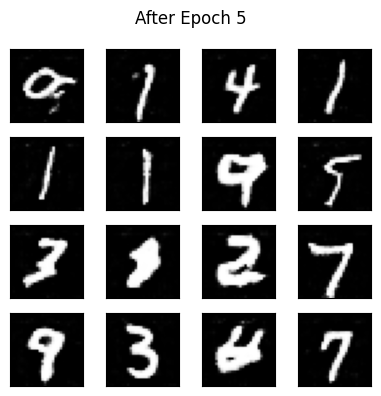

[6/50] Loss_D: 1.0850 Loss_G: 1.3090 D(x): 0.7517 D(G(z)): 0.4929 / 0.1796

[7/50] Loss_D: 1.0893 Loss_G: 1.3178 D(x): 0.7888 D(G(z)): 0.5018 / 0.1536

[8/50] Loss_D: 1.0979 Loss_G: 1.3109 D(x): 0.6863 D(G(z)): 0.4439 / 0.1742

[9/50] Loss_D: 1.1140 Loss_G: 1.2720 D(x): 0.6119 D(G(z)): 0.3693 / 0.2311

[10/50] Loss_D: 1.1051 Loss_G: 1.2990 D(x): 0.5183 D(G(z)): 0.3351 / 0.2700


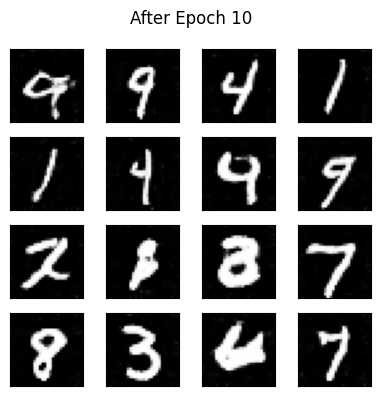

[11/50] Loss_D: 1.1130 Loss_G: 1.2900 D(x): 0.5118 D(G(z)): 0.2325 / 0.4240

[12/50] Loss_D: 1.1027 Loss_G: 1.3127 D(x): 0.5984 D(G(z)): 0.4231 / 0.2850

[13/50] Loss_D: 1.0791 Loss_G: 1.3482 D(x): 0.6847 D(G(z)): 0.3955 / 0.1851

[14/50] Loss_D: 1.0645 Loss_G: 1.3638 D(x): 0.6418 D(G(z)): 0.3527 / 0.3054

[15/50] Loss_D: 1.0500 Loss_G: 1.4007 D(x): 0.5535 D(G(z)): 0.2920 / 0.2833


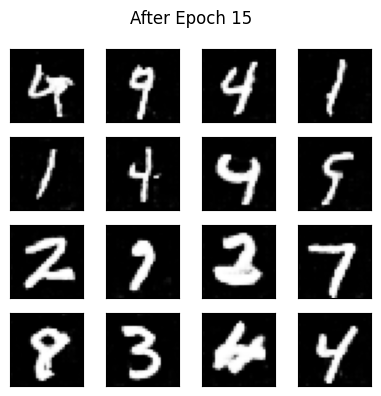

[16/50] Loss_D: 1.0457 Loss_G: 1.4098 D(x): 0.6946 D(G(z)): 0.4265 / 0.2325

[17/50] Loss_D: 1.0215 Loss_G: 1.4413 D(x): 0.7363 D(G(z)): 0.4405 / 0.2026

[18/50] Loss_D: 1.0250 Loss_G: 1.4437 D(x): 0.8127 D(G(z)): 0.4607 / 0.1785

[19/50] Loss_D: 0.9970 Loss_G: 1.4970 D(x): 0.6285 D(G(z)): 0.3047 / 0.2710

[20/50] Loss_D: 0.9834 Loss_G: 1.5216 D(x): 0.7208 D(G(z)): 0.4238 / 0.2511


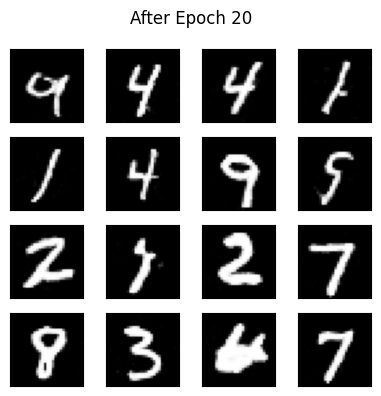

[21/50] Loss_D: 0.9698 Loss_G: 1.5539 D(x): 0.5036 D(G(z)): 0.2313 / 0.3972

[22/50] Loss_D: 0.9587 Loss_G: 1.5620 D(x): 0.7893 D(G(z)): 0.5204 / 0.1276

[23/50] Loss_D: 0.9447 Loss_G: 1.5918 D(x): 0.6328 D(G(z)): 0.3151 / 0.3261

[24/50] Loss_D: 0.9254 Loss_G: 1.6385 D(x): 0.8048 D(G(z)): 0.4587 / 0.1821

[25/50] Loss_D: 0.9278 Loss_G: 1.6405 D(x): 0.7045 D(G(z)): 0.3931 / 0.1808


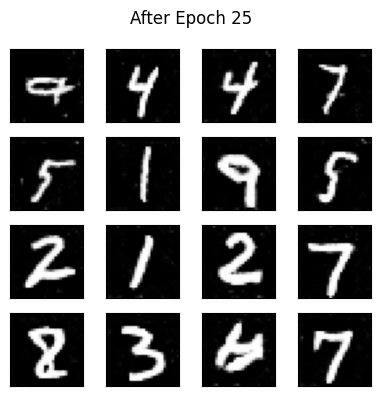

[26/50] Loss_D: 0.9114 Loss_G: 1.6693 D(x): 0.5628 D(G(z)): 0.2458 / 0.2620

[27/50] Loss_D: 0.8916 Loss_G: 1.7129 D(x): 0.6828 D(G(z)): 0.2481 / 0.2117

[28/50] Loss_D: 0.8674 Loss_G: 1.7489 D(x): 0.6912 D(G(z)): 0.3145 / 0.1159

[29/50] Loss_D: 0.8732 Loss_G: 1.7711 D(x): 0.7532 D(G(z)): 0.4792 / 0.1521

[30/50] Loss_D: 0.8631 Loss_G: 1.7768 D(x): 0.8269 D(G(z)): 0.4188 / 0.1551


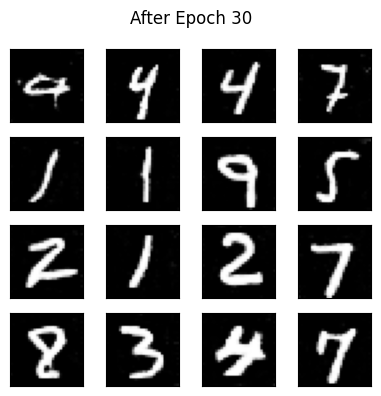

[31/50] Loss_D: 0.8440 Loss_G: 1.8357 D(x): 0.8099 D(G(z)): 0.5612 / 0.1613

[32/50] Loss_D: 0.8309 Loss_G: 1.8358 D(x): 0.7828 D(G(z)): 0.2914 / 0.1511

[33/50] Loss_D: 0.8112 Loss_G: 1.8844 D(x): 0.7080 D(G(z)): 0.2329 / 0.2269

[34/50] Loss_D: 0.8124 Loss_G: 1.9235 D(x): 0.6450 D(G(z)): 0.2383 / 0.2033

[35/50] Loss_D: 0.7955 Loss_G: 1.9415 D(x): 0.8218 D(G(z)): 0.3617 / 0.1624


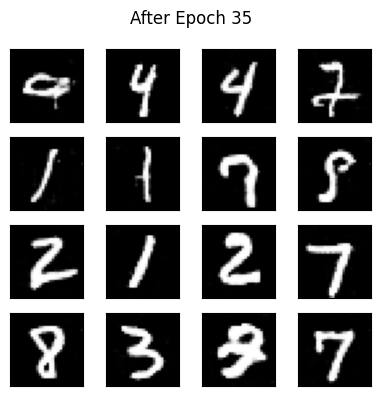

[36/50] Loss_D: 0.8066 Loss_G: 1.9275 D(x): 0.5609 D(G(z)): 0.2197 / 0.3046

[37/50] Loss_D: 0.7819 Loss_G: 1.9732 D(x): 0.8196 D(G(z)): 0.3273 / 0.1130

[38/50] Loss_D: 0.7688 Loss_G: 2.0219 D(x): 0.6800 D(G(z)): 0.1377 / 0.2223

[39/50] Loss_D: 0.7756 Loss_G: 2.0074 D(x): 0.7399 D(G(z)): 0.3384 / 0.1422

[40/50] Loss_D: 0.7430 Loss_G: 2.0739 D(x): 0.8935 D(G(z)): 0.4696 / 0.0908


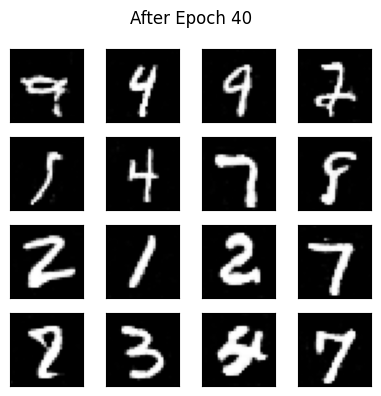

[41/50] Loss_D: 0.7447 Loss_G: 2.0987 D(x): 0.8505 D(G(z)): 0.4172 / 0.0960

[42/50] Loss_D: 0.7421 Loss_G: 2.1030 D(x): 0.8647 D(G(z)): 0.2747 / 0.0920

[43/50] Loss_D: 0.7088 Loss_G: 2.1553 D(x): 0.8508 D(G(z)): 0.3847 / 0.1090

[44/50] Loss_D: 0.7258 Loss_G: 2.1501 D(x): 0.6594 D(G(z)): 0.2547 / 0.2214

[45/50] Loss_D: 0.7039 Loss_G: 2.1925 D(x): 0.7336 D(G(z)): 0.1702 / 0.2204


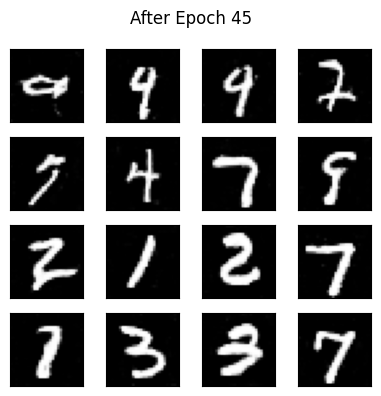

[46/50] Loss_D: 0.7007 Loss_G: 2.2149 D(x): 0.8329 D(G(z)): 0.4410 / 0.0909

[47/50] Loss_D: 0.6834 Loss_G: 2.2601 D(x): 0.9196 D(G(z)): 0.2673 / 0.0446

[48/50] Loss_D: 0.6520 Loss_G: 2.3194 D(x): 0.5307 D(G(z)): 0.0929 / 0.3216

[49/50] Loss_D: 0.6792 Loss_G: 2.2994 D(x): 0.8062 D(G(z)): 0.4617 / 0.1032

[50/50] Loss_D: 0.6655 Loss_G: 2.3172 D(x): 0.3672 D(G(z)): 0.0622 / 0.4131


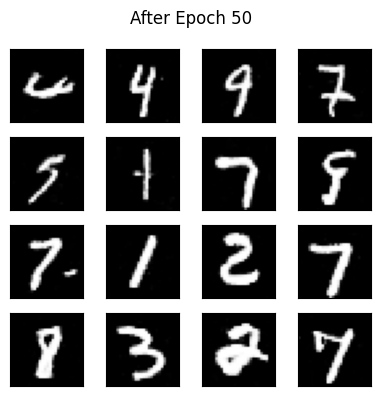

In [ ]:
fixed_noise = torch.randn(100, z_dim, 1, 1, device=device)

for epoch in range(epochs):
    total_D_loss = 0
    total_G_loss = 0

    for i, data in enumerate(dataloader, 0):
        # Train discriminator with real images
        optimizerD.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train discriminator with fake images
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)

        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        total_D_loss += errD.item()
        optimizerD.step()

        # Update generator
        optimizerG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_images)
        errG = criterion(output, label)
        total_G_loss += errG.item()
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

    print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch + 1, epochs,
                     (total_D_loss/len(dataloader)), (total_G_loss/len(dataloader)), D_x, D_G_z1, D_G_z2))

    if (epoch + 1) % 5 == 0:
        with open('weights/netG_epoch_%d.pkl' % (epoch + 1), "wb") as f:
            pickle.dump(netG, f)

        with open('weights/netD_epoch_%d.pkl' % (epoch + 1), "wb") as f:
            pickle.dump(netD, f)

        netG.eval()
        samples = netG(fixed_noise.float())
        netG.train()

        fig, axes = plt.subplots(figsize=(4,4), nrows=4, channelsols=4, sharey=True, sharex=True)
        for ax, img in zip(axes.flatten(), samples):
            img = img.cpu().detach()
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

        fig.suptitle(f'After Epoch {epoch + 1}', fontsize=12)

        plt.tight_layout()
        plt.show()

In [ ]:
with open("/content/weights/netG_epoch_50.pkl", "rb") as f:
    G = pickle.load(f).to(device)

with open("/content/weights/netD_epoch_50.pkl", "rb") as f:
    D = pickle.load(f).to(device)

In [ ]:
import os
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
import numpy as np

import zipfile

dest_folder = "/content/digits"
if not os.path.isdir(dest_folder):
    os.mkdir(dest_folder)

G.eval()

z_dim = 100
z_samples = torch.randn(100, z_dim, 1, 1).to(device)

with torch.no_grad():
    fake_images = G(z_samples)

files_to_zip = []

for i, (image, z) in enumerate(zip(fake_images, z_samples)):
    img_path = os.path.join("/content/digits", f"test-{i}.png")
    z_path = os.path.join("/content/digits", f"test-{i}.txt")

    save_image(image, img_path, normalize=True)
    files_to_zip.append(img_path)

    z = z.view(-1)
    z_array = z.cpu().numpy()

    z_formatted = "[" + ", ".join(f"{x:.18e}" for x in z_array) + "]"

    with open(z_path, 'w') as f:
        f.write(z_formatted)
    files_to_zip.append(z_path)

plt.figure(figsize=(8,8))
grid_img = make_grid(fake_images, nrow=10, normalize=True, padding=2)
plt.imshow(grid_img.permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

zip_filename = "/content/digits/digits.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file, os.path.basename(file))

for file in files_to_zip:
    os.remove(file)

print(f"All files zipped into {zip_filename}")

## Classifier Network

In [ ]:
import torch

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import torch.nn as nn

from torch import optim
from torch.autograd import Variable

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
custom_MNIST_path = '/content/drive/MyDrive/CS4681 - GAN Assignment/Fake_Digits'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

fake_data = datasets.ImageFolder(root=custom_MNIST_path, transform=transform)

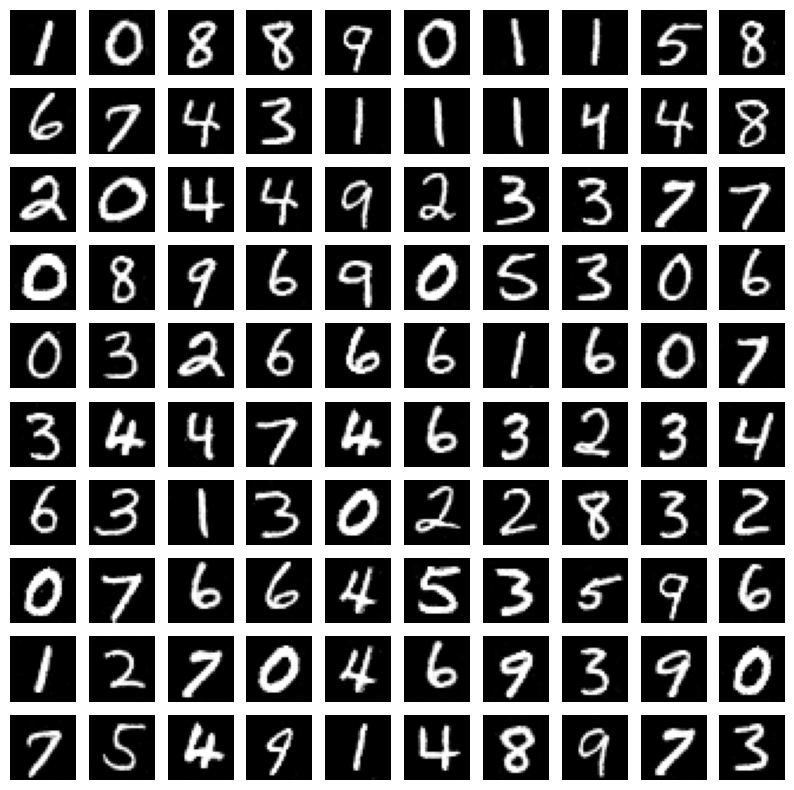

In [ ]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fake_data), size=(1,)).item()
    img, label = fake_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.savefig('fake_mnist_samples.png', bbox_inches='tight')
plt.show()

In [ ]:
MNIST_path='./data'

train_data=datasets.MNIST(
    root=MNIST_path,
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data=datasets.MNIST(
    root=MNIST_path,
    train=False,
    transform=ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 54270575.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1634803.82it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 11835186.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2827746.59it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
print(train_data.data.size())
print(test_data.data.size())
print(len(fake_data))

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
100


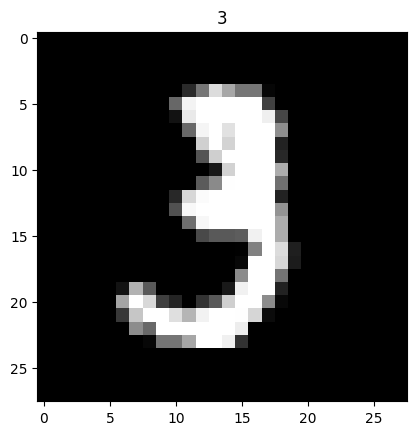

In [ ]:
plt.imshow(train_data.data[10], cmap='gray')
plt.title('%i' % train_data.targets[10])
plt.show()

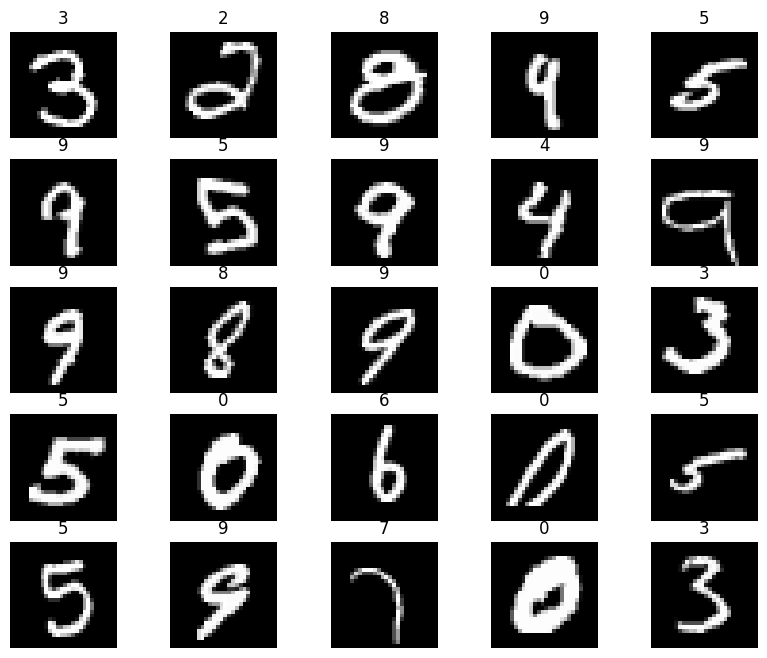

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

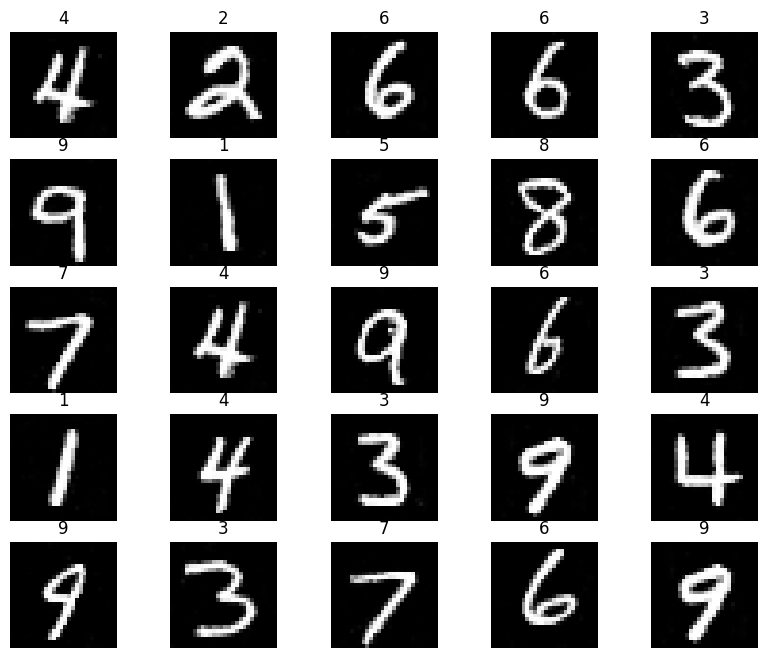

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fake_data), size=(1,)).item()
    img, label = fake_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'fake': torch.utils.data.DataLoader(fake_data,
                                        batch_size=100,
                                        shuffle=True,
                                        num_workers=1)
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7b7d1c994880>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7b7d1c996290>,
 'fake': <torch.utils.data.dataloader.DataLoader at 0x7b7d1bc9e6b0>}

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=36,  #16
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(36, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [ ]:
cnn=CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(cnn.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [ ]:
num_epochs = 10

def train(num_epochs, cnn, loaders):

    cnn.train()

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        correct = 0
        total = 0
        train_loss = 0

        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(output, 1)  # Get the index of the max log-probability
            correct += (predicted == b_y).sum().item()  # Increment the number of correct predictions
            total += b_y.size(0)  # Increment the total number of predictions
            train_loss += loss.item()

        epoch_accuracy = 100 * correct / total
        print('Epoch [{}/{}], Loss: {:.4f},  Training Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, train_loss / 600, epoch_accuracy))
    pass

train(num_epochs, cnn, loaders)

Epoch [1/10], Loss: 0.1521,  Training Accuracy: 95.19%
Epoch [2/10], Loss: 0.0603,  Training Accuracy: 98.08%
Epoch [3/10], Loss: 0.0500,  Training Accuracy: 98.42%
Epoch [4/10], Loss: 0.0477,  Training Accuracy: 98.51%
Epoch [5/10], Loss: 0.0430,  Training Accuracy: 98.69%
Epoch [6/10], Loss: 0.0430,  Training Accuracy: 98.69%
Epoch [7/10], Loss: 0.0393,  Training Accuracy: 98.79%
Epoch [8/10], Loss: 0.0377,  Training Accuracy: 98.86%
Epoch [9/10], Loss: 0.0421,  Training Accuracy: 98.81%
Epoch [10/10], Loss: 0.0433,  Training Accuracy: 98.82%


In [ ]:
import pickle

with open('C.pkl', 'wb') as f:
    pickle.dump(cnn, f)

In [ ]:
def test_all():
  cnn.eval()
  with torch.no_grad():
    correct=0
    total=0
    for images, labels in loaders['test']:
      test_output,last_layer=cnn(images)
      pred_y=torch.max(test_output,1)[1].data.squeeze()
      accuracy=(pred_y==labels).sum().item()/float(labels.size(0))
      pass
    print('Test Acc %.2f' % accuracy)
    pass


test_all()

Test Acc 0.99


Test Acc for original MNIST  0.99
Error Rate for original MNIST  0.01


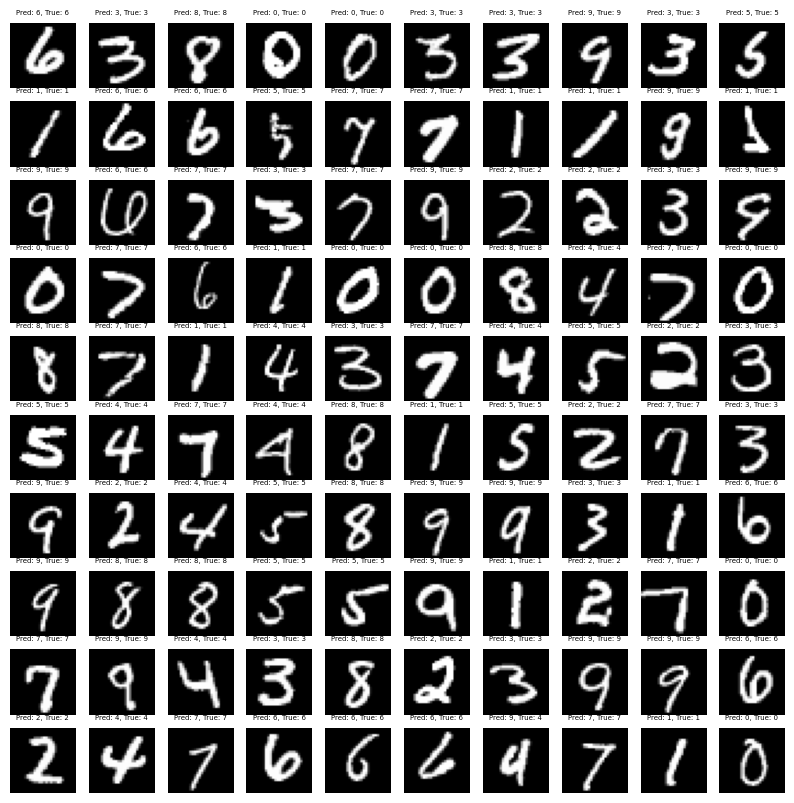

In [ ]:
def test_original_mnist():
  cnn.eval()
  with torch.no_grad():
    correct=0
    total=0
    images, labels = next(iter(loaders['test']))
    test_output,last_layer=cnn(images)
    pred_y=torch.max(test_output,1)[1].data.squeeze()
    accuracy=(pred_y==labels).sum().item()/float(labels.size(0))
    error_rate = 1 - accuracy

    print('Test Acc for original MNIST  %.2f' % accuracy)
    print('Error Rate for original MNIST  %.2f' % error_rate)

    # Plot the images along with their predicted labels
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(10, 10, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Pred: {pred_y[i].item()}, True: {labels[i].item()}', fontsize = 5)
        plt.axis('off')

test_original_mnist()

In [ ]:
def test_fake_mnist():
  cnn.eval()
  with torch.no_grad():
    correct=0
    total=0
    images, labels = next(iter(loaders['fake']))

    test_output,last_layer=cnn(images)
    pred_y=torch.max(test_output,1)[1].data.squeeze()
    accuracy=(pred_y==labels).sum().item()/float(labels.size(0))
    error_rate = 1 - accuracy

    print('Test Acc for fake MNIST  %.2f' % accuracy)
    print('Error Rate for fake MNIST  %.2f' % error_rate)

test_fake_mnist()

Test Acc for fake MNIST  1.00
Error Rate for fake MNIST  0.00


In [ ]:
from collections import Counter

def check_predictions_distribution(loader):
    cnn.eval()
    with torch.no_grad():
        all_preds = []
        for images, _ in loader:
            test_output, _ = cnn(images)
            preds = torch.max(test_output, 1)[1].detach().cpu().numpy()
            all_preds.extend(preds)

        class_counts = Counter(all_preds)
        for class_id, count in class_counts.items():
            print(f'Predicted Class {class_id}: {count} samples')

check_predictions_distribution(loaders['fake'])

Predicted Class 9: 10 samples
Predicted Class 3: 10 samples
Predicted Class 1: 10 samples
Predicted Class 8: 10 samples
Predicted Class 2: 10 samples
Predicted Class 7: 10 samples
Predicted Class 6: 10 samples
Predicted Class 0: 10 samples
Predicted Class 5: 10 samples
Predicted Class 4: 10 samples


In [ ]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
actual_number = lbls[:100].numpy()

In [ ]:
test_output,last_layer=cnn(imgs[:100])
pred_y=torch.max(test_output,1)[1].data.numpy().squeeze()

print(f'Prediction number {pred_y}')
print(f'Actual number {actual_number}')

Prediction number [5 9 8 9 1 1 3 5 3 1 7 2 4 6 4 5 4 3 9 3 9 7 7 3 0 9 8 9 7 8 4 1 4 2 0 4 2
 8 2 6 7 3 2 3 0 1 4 8 5 2 5 3 1 8 8 5 8 6 0 3 3 4 7 2 3 9 3 7 3 2 1 9 0 4
 3 1 7 8 6 1 8 9 9 7 2 6 7 0 9 7 9 7 0 6 4 7 5 7 0 0]
Actual number [5 9 8 9 1 1 3 5 3 1 7 2 4 6 4 5 4 3 9 3 9 7 7 3 0 9 8 9 7 8 4 1 9 2 0 4 2
 8 2 6 7 3 2 3 0 1 4 8 5 8 5 3 1 8 8 5 8 6 0 3 3 4 7 2 3 9 3 7 3 2 1 9 0 4
 3 1 7 8 6 1 8 9 9 7 2 6 9 0 9 7 9 7 0 6 4 7 5 7 0 0]


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm=confusion_matrix(actual_number, pred_y)

Confusion matrix, without normalization
[[ 9  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0]
 [ 0  0  1  0  0  0  0  0 10  0]
 [ 0  0  0  0  1  0  0  1  0 12]]


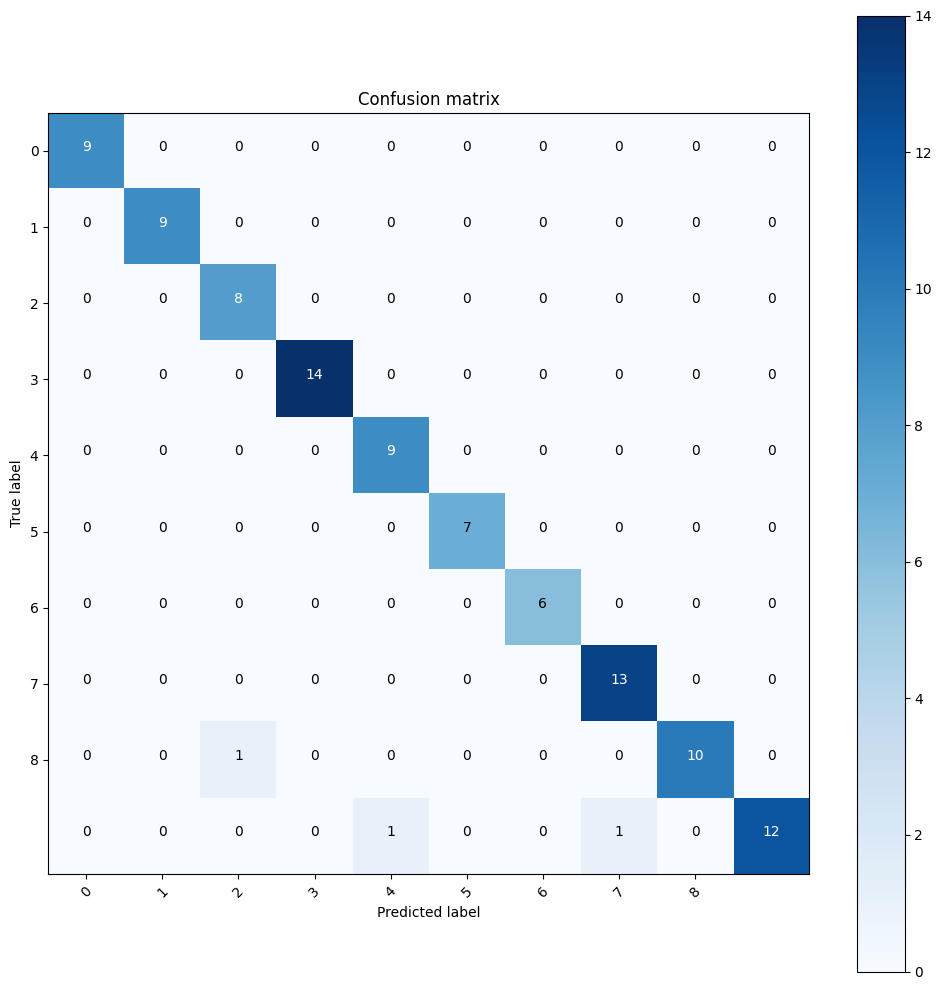

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, [str(i) for i in range(0,9)])